In [34]:
from dotenv import load_dotenv
load_dotenv()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
from datetime import datetime
import time
from typing import Dict, List, Any, Optional
import json

In [35]:
try:
    from fredapi import Fred
    _HAS_FREDAPI = True
except Exception:
    _HAS_FREDAPI = False

FRED_API_KEY = os.getenv("FRED_API_KEY")
if not FRED_API_KEY:
    raise RuntimeError(
        "FRED_API_KEY not found"
    )

if _HAS_FREDAPI:
    fred = Fred(api_key=FRED_API_KEY)
    
EIA_API_KEY = os.getenv("EIA_API_KEY")
if not EIA_API_KEY:
    raise RuntimeError(
        "EIA_API_KEY not found in environment."
    )

# Helper Functions

### FRED

In [36]:
def fetch_fred_series(series_id, api_key, start=None, end=None,
                      use_fredapi=None, fred=None, verbose=True):
    """
    Fetch a FRED series. Try fredapi (if provided), else HTTP API.
    """
    # Try fredapi first if available
    if use_fredapi and fred is not None:
        try:
            ser = fred.get_series(series_id,
                                  observation_start=start,
                                  observation_end=end)
            ser.name = series_id
            return ser
        except Exception as e:
            if verbose:
                print(f"fredapi get_series failed for {series_id}: {e!s}")
            # fall through to HTTP fallback

    # HTTP API fallback
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {"series_id": series_id, "api_key": api_key, "file_type": "json"}
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end

    try:
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
    except requests.HTTPError as e:
        # try to extract API message if possible
        try:
            msg = r.json().get("message", str(e))
        except Exception:
            msg = str(e)
        raise ValueError(f"HTTP error fetching '{series_id}': {msg}")

    j = r.json()
    obs = j.get("observations", [])
    if not obs:
        raise ValueError(f"No observations returned for '{series_id}'. "
                         "Check the series id on FRED (possible typo).")
    dates = [o["date"] for o in obs]
    vals = [np.nan if o["value"] == "." else float(o["value"]) for o in obs]
    ser = pd.Series(vals, index=pd.to_datetime(dates), name=series_id).sort_index()
    return ser


def search_fred(query, api_key, fred=None, use_fredapi=None, limit=20):
    """
    Search FRED for a query string. Returns a pandas.DataFrame (id, title, frequency).
    """
    if use_fredapi and fred is not None:
        try:
            res = fred.search(query, limit=limit)
            # fredapi returns a DataFrame-like object
            if isinstance(res, pd.DataFrame):
                return res[["id", "title", "frequency"]]
        except Exception:
            pass

    # HTTP search fallback
    url = "https://api.stlouisfed.org/fred/series/search"
    params = {"search_text": query, "api_key": api_key, "file_type": "json", "limit": limit}
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    j = r.json()
    results = j.get("seriess", [])
    if not results:
        return pd.DataFrame(columns=["id", "title", "frequency"])
    df = pd.DataFrame(results)
    return df[["id", "title", "frequency"]]

In [37]:
def check_fred_series(series_ids, api_key=None, search_if_missing=True, search_limit=5, verbose=True):
	"""
	Check existence of FRED series ids and return a DataFrame with metadata.
	Parameters:
		- series_ids: list[str] of FRED series ids to check
		- search_if_missing: run a FRED text search for missing ids (top results)
		- search_limit: max suggestions per missing id
		- verbose: print progress/messages
	Returns:
		pandas.DataFrame with columns:
		['series_id', 'exists', 'title', 'frequency', 'seasonal_adjustment',
			'units', 'last_updated', 'notes', 'search_suggestions']
		search_suggestions is a list of tuples: (id, title, frequency)
	"""
	if api_key is None:
		api_key = FRED_API_KEY
	if not api_key:
		raise RuntimeError(
			"FRED API key not provided."
		)

	series_url = "https://api.stlouisfed.org/fred/series"
	search_url = "https://api.stlouisfed.org/fred/series/search"

	rows = []
	for sid in series_ids:
		row = {
			"series_id": sid,
			"exists": False,
			"title": None,
			"frequency": None,
			"seasonal_adjustment": None,
			"units": None,
			"last_updated": None,
			"notes": None,
			"search_suggestions": [],
		}

		params = {"series_id": sid, "api_key": api_key, "file_type": "json"}
		try:
			r = requests.get(series_url, params=params, timeout=30)
			r.raise_for_status()
			j = r.json()
			meta = j.get("seriess") or j.get("series")
			if isinstance(meta, list):
				meta = meta[0] if meta else None
			if meta:
				row["exists"] = True
				row["title"] = meta.get("title")
				row["frequency"] = meta.get("frequency")
				row["seasonal_adjustment"] = meta.get("seasonal_adjustment")
				row["units"] = meta.get("units")
				row["last_updated"] = meta.get("last_updated")
			else:
				row["notes"] = "No metadata returned (empty 'seriess')."
		except requests.HTTPError as exc:
			# try to parse API message from JSON if available
			try:
				msg = r.json().get("message", str(exc))
			except Exception:
				msg = str(exc)
			row["notes"] = f"HTTP error: {msg}"
		except Exception as exc:
			row["notes"] = f"Error: {exc}"

		# If missing, run a text search to suggest candidates
		if (not row["exists"]) and search_if_missing:
			sparams = {
				"search_text": sid,
				"api_key": api_key,
				"file_type": "json",
				"limit": search_limit,
			}
			try:
				rs = requests.get(search_url, params=sparams, timeout=30)
				rs.raise_for_status()
				js = rs.json()
				results = js.get("seriess", []) or []
				suggestions = []
				for res in results:
					suggestions.append(
						(res.get("id"), res.get("title"), res.get("frequency"))
					)
				row["search_suggestions"] = suggestions
				if not suggestions and row["notes"] is None:
					row["notes"] = "No search suggestions returned."
			except Exception as exc:
				# append search failure information to notes
				note = f"Search failed: {exc}"
				row["notes"] = f"{row['notes']} | {note}" if row["notes"] else note

		rows.append(row)

		if verbose:
			if row["exists"]:
				print(f"FOUND: {sid}  - {row['title']}  [{row['frequency']}]")
			else:
				print(f"MISSING: {sid}  - {row['notes']}")
				if row["search_suggestions"]:
					print("  Suggestions:")
					for s in row["search_suggestions"]:
						print(f"   - {s[0]} : {s[1]} ({s[2]})")

	return pd.DataFrame(rows)

def fred_get_series(series_id, start=None, end=None):
    """Fetch observations from FRED series/observations and return a pd.Series."""
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {"series_id": series_id, "api_key": FRED_API_KEY, "file_type": "json"}
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    j = r.json()
    obs = j.get("observations", []) or []
    dates = [o["date"] for o in obs]
    vals = [np.nan if o["value"] == "." else float(o["value"]) for o in obs]
    ser = pd.Series(vals, index=pd.to_datetime(dates), name=series_id)
    ser = ser.sort_index()
    return ser

### EIA

In [38]:
# EIA v2 helpers (no caching)
from dotenv import load_dotenv
load_dotenv()

import os
import requests
import pandas as pd

EIA_API_KEY = os.getenv("EIA_API_KEY")
if not EIA_API_KEY:
    raise RuntimeError("EIA_API_KEY not found in environment (.env)")

# optional holiday calendar for release-day shifts
try:
    import holidays
    US_HOLIDAYS = holidays.UnitedStates()
except Exception:
    US_HOLIDAYS = None


def _find_data(obj):
    """Recursively find the first 'data' list in an EIA v2 JSON response."""
    if isinstance(obj, dict):
        if "data" in obj and isinstance(obj["data"], list):
            return obj["data"]
        for v in obj.values():
            found = _find_data(v)
            if found is not None:
                return found
    elif isinstance(obj, list):
        for it in obj:
            found = _find_data(it)
            if found is not None:
                return found
    return None


def _find_key(obj, keys):
    """Recursively search for the first occurrence of any key in keys."""
    if not isinstance(obj, dict):
        return None
    for k in keys:
        if k in obj and obj[k] is not None:
            return obj[k]
    for v in obj.values():
        if isinstance(v, dict):
            res = _find_key(v, keys)
            if res is not None:
                return res
        elif isinstance(v, list):
            for item in v:
                if isinstance(item, dict):
                    res = _find_key(item, keys)
                    if res is not None:
                        return res
    return None


def _parse_date(ds):
    """Robust date parsing for EIA period/date strings."""
    try:
        dt = pd.to_datetime(ds, errors="coerce")
        if not pd.isna(dt):
            return dt
    except Exception:
        pass
    s = str(ds)
    if s.isdigit():
        if len(s) == 8:
            try:
                return pd.to_datetime(s, format="%Y%m%d", errors="coerce")
            except Exception:
                return pd.NaT
        if len(s) == 6:
            try:
                return pd.to_datetime(s, format="%Y%m", errors="coerce")
            except Exception:
                return pd.NaT
        if len(s) == 4:
            try:
                return pd.to_datetime(s, format="%Y", errors="coerce")
            except Exception:
                return pd.NaT
    return pd.NaT


def eia_fetch_series_v2(series_id: str, api_key: str = None, timeout: int = 30):
    """
    Fetch an EIA v2 series by series_id and return (pd.Series, metadata dict).
    This function does NOT cache; it requests the API on each call.
    """
    if api_key is None:
        api_key = EIA_API_KEY
    url = f"https://api.eia.gov/v2/seriesid/{series_id}"
    r = requests.get(url, params={"api_key": api_key}, timeout=timeout)
    r.raise_for_status()
    j = r.json()

    data = _find_data(j)
    if not data:
        return pd.Series(dtype="float64", name=series_id), {
            "series_id": series_id,
            "name": _find_key(j, ["name", "title", "series_name"]),
            "units": _find_key(j, ["units", "unit"]),
            "frequency": _find_key(j, ["frequency", "f"]),
        }

    items = []
    for row in data:
        date_str = (
            row.get("period")
            or row.get("period_end")
            or row.get("date")
            or row.get("yyyymm")
            or row.get("yyyymmdd")
        )
        val = row.get("value")
        if date_str is None or val is None:
            continue
        dt = _parse_date(date_str)
        if pd.isna(dt):
            continue
        v = pd.to_numeric(val, errors="coerce")
        if pd.isna(v):
            continue
        items.append((dt, v))

    if not items:
        ser = pd.Series(dtype="float64", name=series_id)
    else:
        items.sort(key=lambda x: x[0])
        idx = pd.DatetimeIndex([d for d, _ in items])
        vals = [v for _, v in items]
        ser = pd.Series(vals, index=idx, name=series_id)

    meta = {
        "series_id": _find_key(j, ["series_id", "id", "seriesId"]) or series_id,
        "name": _find_key(j, ["name", "title", "series_name", "description"]),
        "units": _find_key(j, ["units", "unit"]),
        "frequency": _find_key(j, ["frequency", "f"]),
    }
    return ser, meta


def eia_fetch_series_batch(series_ids, api_key: str = None, timeout: int = 30):
    """
    Fetch multiple series ids sequentially (no caching). Returns (series_map, meta_map).
    """
    if api_key is None:
        api_key = EIA_API_KEY
    series_map = {}
    meta_map = {}
    for sid in series_ids:
        try:
            s, m = eia_fetch_series_v2(sid, api_key=api_key, timeout=timeout)
            series_map[sid] = s
            meta_map[sid] = m
            print(f"[OK] {sid}: {len(s)} obs, {s.index[0].date() if len(s) else 'no-data'} -> "
                  f"{s.index[-1].date() if len(s) else 'no-data'}")
        except Exception as e:
            print(f"[ERR] {sid}: {e}")
            series_map[sid] = pd.Series(dtype="float64", name=sid)
            meta_map[sid] = {"series_id": sid, "error": str(e)}
    return series_map, meta_map


def map_weekly_to_release_days(weekly_series: pd.Series, holiday_cal=None):
    """
    Map weekly observations (week-ending) to EIA public release day
    (default: next Monday + 2 days = Wednesday; shift to Thu on Mon/Tue holidays).
    """
    if holiday_cal is None:
        holiday_cal = US_HOLIDAYS

    out = {}
    for week_end, val in weekly_series.items():
        week_end = pd.to_datetime(week_end)
        next_mon = (week_end + pd.Timedelta(days=3)).normalize()
        rel = next_mon + pd.Timedelta(days=2)  # Wednesday
        try:
            mon = next_mon.date()
            tue = (next_mon + pd.Timedelta(days=1)).date()
            if holiday_cal is not None and (mon in holiday_cal or tue in holiday_cal):
                rel = rel + pd.Timedelta(days=1)  # shift to Thu
        except Exception:
            pass
        out[pd.Timestamp(rel)] = val

    s = pd.Series(out).sort_index()
    s.name = (weekly_series.name + "_release") if isinstance(weekly_series.name, str) else "eia_release"
    return s


def weekly_asof_daily(weekly_release: pd.Series, daily_index: pd.DatetimeIndex = None):
    """
    Forward-fill weekly_release over a daily_index (value becomes known on release day).
    If daily_index is None, it's created from min->max of weekly_release.
    """
    if daily_index is None:
        if len(weekly_release) == 0:
            return pd.Series(dtype="float64")
        daily_index = pd.date_range(weekly_release.index.min(), weekly_release.index.max(), freq="D")
    s = weekly_release.reindex(daily_index).ffill()
    s.name = weekly_release.name.replace("_release", "") if isinstance(weekly_release.name, str) else "eia_asof"
    return s

### 1) `GDPDEF` & `M2SL`

In [39]:
series_ids = ["GDPDEF", "M2SL"]
series_1 = {}
for sid in series_ids:
    series_1[sid] = fetch_fred_series(sid, api_key=FRED_API_KEY,
                                    use_fredapi=_HAS_FREDAPI, fred=fred if _HAS_FREDAPI else None)
    print(sid, ":", series_1[sid].index[0].date(), "->", series_1[sid].index[-1].date(),
          f"({len(series_1[sid])} obs)")

gdpdef = series_1["GDPDEF"]
m2 = series_1["M2SL"]

GDPDEF : 1947-01-01 -> 2025-04-01 (314 obs)
M2SL : 1959-01-01 -> 2025-07-01 (799 obs)


In [40]:
gdpdef.index = pd.to_datetime(gdpdef.index)
m2.index = pd.to_datetime(m2.index)
gdpdef = gdpdef.sort_index()
m2 = m2.sort_index()

gdpdef.name = "GDPDEF"
m2.name = "M2SL"

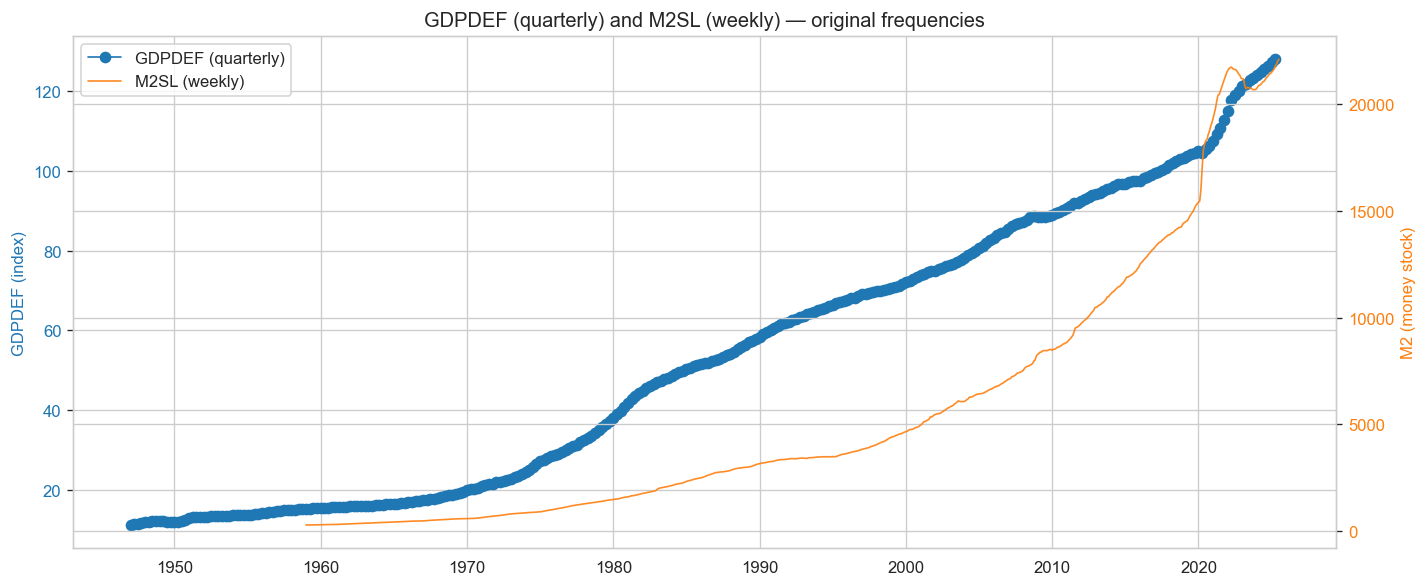

In [41]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# GDPDEF (quarterly) - show markers so quarterly points are visible
ax1.plot(gdpdef.index, gdpdef.values, color="C0", marker="o", linestyle="-",
         linewidth=1, label=f"{gdpdef.name} (quarterly)")
ax1.set_ylabel("GDPDEF (index)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")

# M2 (weekly) on secondary axis
ax2 = ax1.twinx()
ax2.plot(m2.index, m2.values, color="C1", linewidth=1, alpha=0.9,
         label=f"{m2.name} (weekly)")
ax2.set_ylabel("M2 (money stock)", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

ax1.set_title("GDPDEF (quarterly) and M2SL (weekly) — original frequencies")
fig.tight_layout()
plt.show()

### 2) `INDPRO`, `UNRATE`, `TCU`, `CFNAI`, & `CPIAUCSL`

In [42]:
to_check = [
    "INDPRO",
    "UNRATE",
    "TCU",
    "CFNAI",
    "CPIAUCSL",
]
df = check_fred_series(to_check)   
df

FOUND: INDPRO  - Industrial Production: Total Index  [Monthly]
FOUND: UNRATE  - Unemployment Rate  [Monthly]
FOUND: TCU  - Capacity Utilization: Total Index  [Monthly]
FOUND: CFNAI  - Chicago Fed National Activity Index  [Monthly]
FOUND: CPIAUCSL  - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average  [Monthly]


,series_id,exists,title,frequency,seasonal_adjustment,units,last_updated,notes,search_suggestions
0,INDPRO,True,Industrial Production: Total Index,Monthly,Seasonally Adjusted,Index 2017=100,2025-08-15 08:27:14-05,None,[]
1,UNRATE,True,Unemployment Rate,Monthly,Seasonally Adjusted,Percent,2025-09-05 07:51:01-05,None,[]
2,TCU,True,Capacity Utilization: Total Index,Monthly,Seasonally Adjusted,Percent,2025-08-15 08:21:47-05,None,[]
3,CFNAI,True,Chicago Fed National Activity Index,Monthly,Not Seasonally Adjusted,Index,2025-08-25 07:34:01-05,None,[]
4,CPIAUCSL,True,Consumer Price Index for All Urban Consumers: ...,Monthly,Seasonally Adjusted,Index 1982-1984=100,2025-09-11 07:42:02-05,None,[]


In [43]:
series_ids = to_check
series_2 = {}
for sid in series_ids:
    series_2[sid] = fetch_fred_series(sid, api_key=FRED_API_KEY,
                                    use_fredapi=_HAS_FREDAPI, fred=fred if _HAS_FREDAPI else None)
    print(sid, ":", series_2[sid].index[0].date(), "->", series_2[sid].index[-1].date(),
          f"({len(series_2[sid])} obs)")

INDPRO = series_2["INDPRO"]
UNRATE = series_2["UNRATE"]
TCU = series_2["TCU"]
CFNAI = series_2["CFNAI"]
CPIAUCSL = series_2["CPIAUCSL"]

INDPRO : 1919-01-01 -> 2025-07-01 (1279 obs)
UNRATE : 1948-01-01 -> 2025-08-01 (932 obs)
TCU : 1967-01-01 -> 2025-07-01 (703 obs)
CFNAI : 1967-03-01 -> 2025-07-01 (701 obs)
CPIAUCSL : 1947-01-01 -> 2025-08-01 (944 obs)


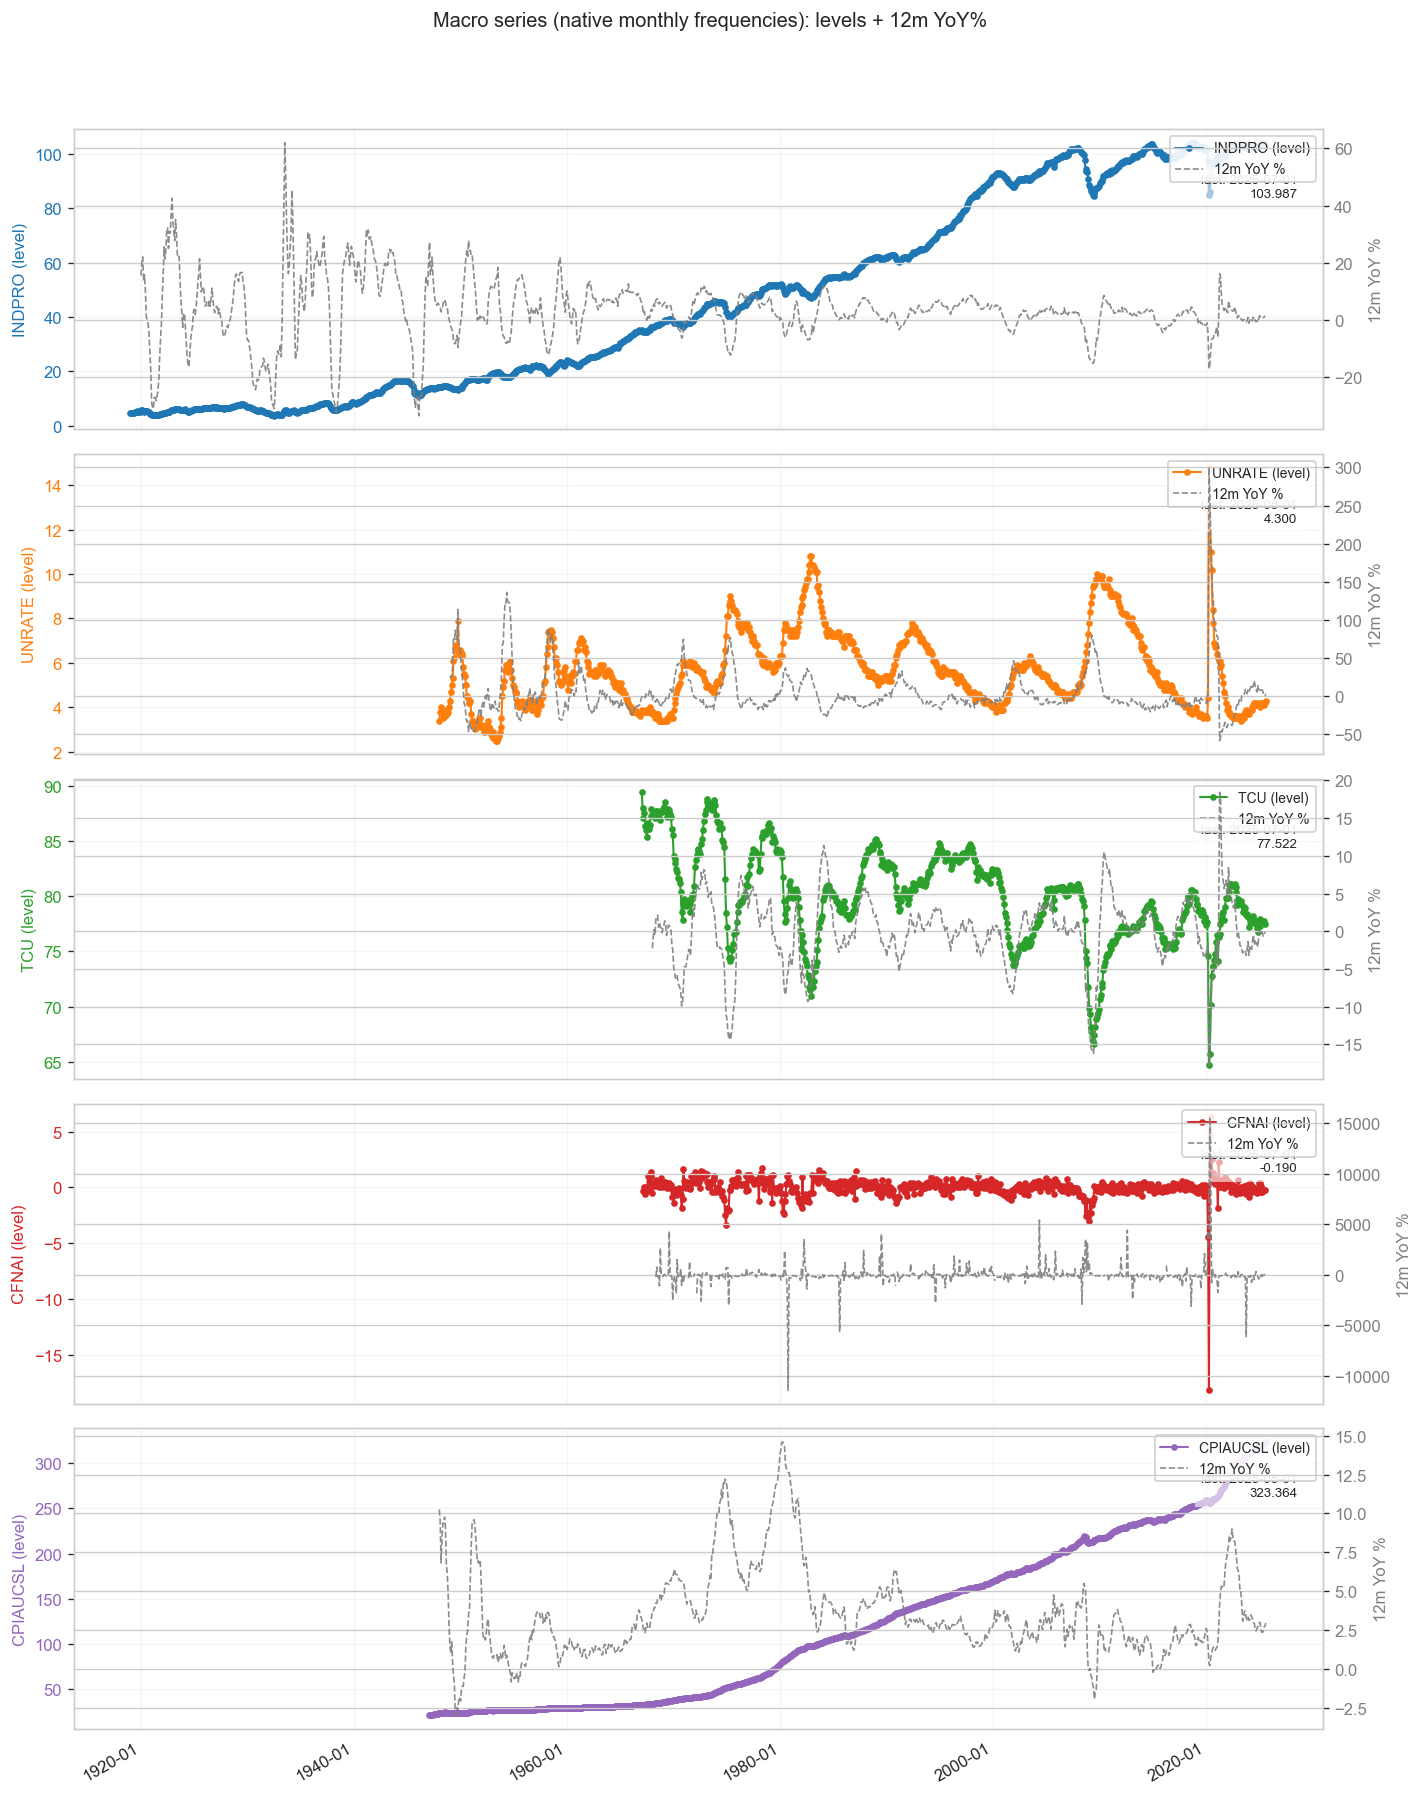

In [44]:
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120

series_plot = {
    "INDPRO": INDPRO,
    "UNRATE": UNRATE,
    "TCU": TCU,
    "CFNAI": CFNAI,
    "CPIAUCSL": CPIAUCSL,
}

# Ensure series are 1-D pandas.Series with datetime index
for k in list(series_plot.keys()):
    ser = series_plot[k]
    if isinstance(ser, pd.DataFrame):
        if ser.shape[1] == 1:
            ser = ser.iloc[:, 0]
        else:
            raise ValueError(f"{k} is a DataFrame with >1 columns")
    ser = ser.copy()
    ser.index = pd.to_datetime(ser.index)
    ser = ser.sort_index()
    ser.name = k
    series_plot[k] = ser

n = len(series_plot)
fig, axes = plt.subplots(n, 1, sharex=True, figsize=(12, 3 * n))
if n == 1:
    axes = [axes]

palette = sns.color_palette("tab10", n_colors=n)

for i, (k, ser) in enumerate(series_plot.items()):
    ax = axes[i]
    col = palette[i % len(palette)]

    # Level (native frequency)
    ax.plot(
        ser.index,
        ser.values,
        color=col,
        marker="o",
        markersize=3,
        linewidth=1.25,
        label=f"{k} (level)",
    )
    ax.set_ylabel(f"{k} (level)", color=col)
    ax.tick_params(axis="y", labelcolor=col)

    # 12-month YoY percent change (works at monthly cadence)
    yoy = ser.pct_change(12) * 100
    ax2 = ax.twinx()
    ax2.plot(
        yoy.index,
        yoy.values,
        color="gray",
        linestyle="--",
        linewidth=1,
        alpha=0.9,
        label="12m YoY %",
    )
    ax2.set_ylabel("12m YoY %", color="gray")
    ax2.tick_params(axis="y", labelcolor="gray")

    # Legend combining both lines
    l1, lab1 = ax.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    if l1 or l2:
        ax.legend(
            l1 + l2,
            lab1 + lab2,
            loc="upper right",
            fontsize="small",
            framealpha=0.9,
        )

    # Annotate last observation
    last_dt = ser.index[-1]
    last_val = ser.iloc[-1]
    ax.annotate(
        f"last: {last_dt.date()}\n{last_val:.3f}",
        xy=(0.98, 0.85),
        xycoords="axes fraction",
        ha="right",
        va="top",
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.6, linewidth=0.4),
    )
    ax.grid(True, alpha=0.2)

# X-axis formatting on the bottom subplot
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=30)

fig.suptitle(
    "Macro series (native monthly frequencies): levels + 12m YoY%",
    fontsize=12,
    y=0.995,
)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 3) EIA-Derived Features

In [45]:
series_id = "PET.WPULEUS3.W"  # EIA v2 series id for refinery utilization

weekly_ser, meta = eia_fetch_series_v2(series_id)
if len(weekly_ser) == 0:
    raise RuntimeError(f"No data returned for {series_id}; check the id or API key.")

In [46]:
# 13-week moving average (smoothing)
ma_13 = weekly_ser.rolling(13, min_periods=1).mean()

# map weekly -> release day and make an as-of daily series
release_ser = map_weekly_to_release_days(weekly_ser)
daily_idx = pd.date_range(release_ser.index.min(), release_ser.index.max(), freq="D")
asof_daily = weekly_asof_daily(release_ser, daily_idx)

print(f"Series: {series_id}")
print("Name:", meta.get("name"))
print("Units:", meta.get("units"))
print(f"Observations: {len(weekly_ser)}")
print("Range:", weekly_ser.index[0].date(), "->", weekly_ser.index[-1].date())

Series: PET.WPULEUS3.W
Name: EIA petroleum gas survey data
Units: %
Observations: 1819
Range: 1990-11-02 -> 2025-09-05


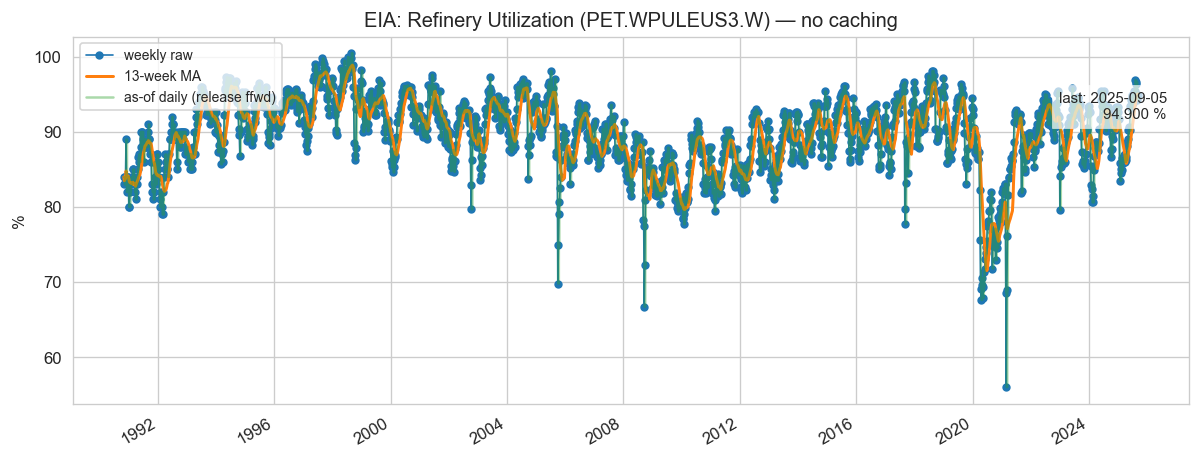

In [47]:
# Plot: weekly raw, 13-wk MA, and as-of daily step
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(weekly_ser.index, weekly_ser.values, "o-", ms=4, lw=1.0, label="weekly raw")
ax.plot(ma_13.index, ma_13.values, "-", lw=1.8, color="C1", label="13-week MA")
ax.step(asof_daily.index, asof_daily.values, where="post", color="C2", alpha=0.4,
        label="as-of daily (release ffwd)")

ax.set_title("EIA: Refinery Utilization (PET.WPULEUS3.W) — no caching")
ax.set_ylabel(meta.get("units") or "value")
ax.legend(loc="upper left", fontsize="small")

# annotate last observation
last_dt = weekly_ser.index[-1].date()
last_val = weekly_ser.iloc[-1]
ax.annotate(f"last: {last_dt}\n{last_val:.3f} {meta.get('units','')}",
            xy=(0.98, 0.85), xycoords="axes fraction",
            ha="right", va="top", fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, linewidth=0.4))

fig.autofmt_xdate(rotation=30)
plt.show()

### 4) `T5YIE`

In [ ]:
series_id = "T5YIE"  
series_3 = fetch_fred_series(series_id, api_key=FRED_API_KEY, use_fredapi=_HAS_FREDAPI, fred=fred if _HAS_FREDAPI else None)

print(series_id, ":", series_3.index[0].date(), "->", series_3.index[-1].date(),
          f"({len(series_3)} obs)")

TFYIE = series_3

T5YIE : 2003-01-02 -> 2025-09-12 (5922 obs)


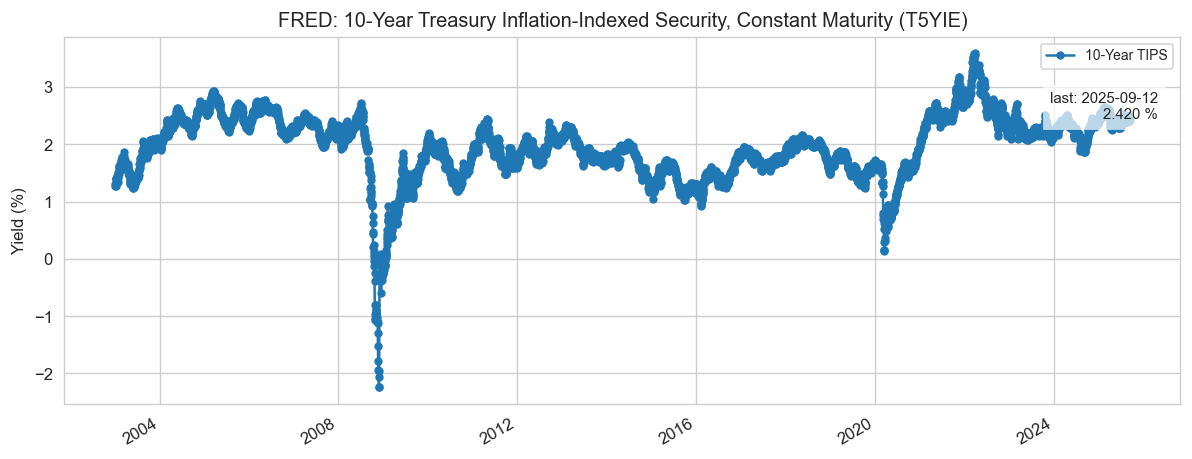

In [49]:
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120


fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(TFYIE.index, TFYIE.values, "o-", ms=4, label="10-Year TIPS")
ax.set_title("FRED: 10-Year Treasury Inflation-Indexed Security, Constant Maturity (T5YIE)")
ax.set_ylabel("Yield (%)")
ax.legend(loc="upper right", fontsize="small")
# annotate last observation
last_dt = TFYIE.index[-1].date()
last_val = TFYIE.iloc[-1]
ax.annotate(f"last: {last_dt}\n{last_val:.3f} %",
            xy=(0.98, 0.85), xycoords="axes fraction",
            ha="right", va="top", fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, linewidth=0.4))
fig.autofmt_xdate(rotation=30)
plt.show()

### 5) `USSLIND`

In [58]:
series_id = "USSLIND"  
series_4 = fetch_fred_series(series_id, api_key=FRED_API_KEY, use_fredapi=_HAS_FREDAPI, fred=fred if _HAS_FREDAPI else None)

print(series_id, ":", series_4.index[0].date(), "->", series_4.index[-1].date(),
          f"({len(series_4)} obs)")

USSLIND = series_4

USSLIND : 1982-01-01 -> 2020-02-01 (458 obs)


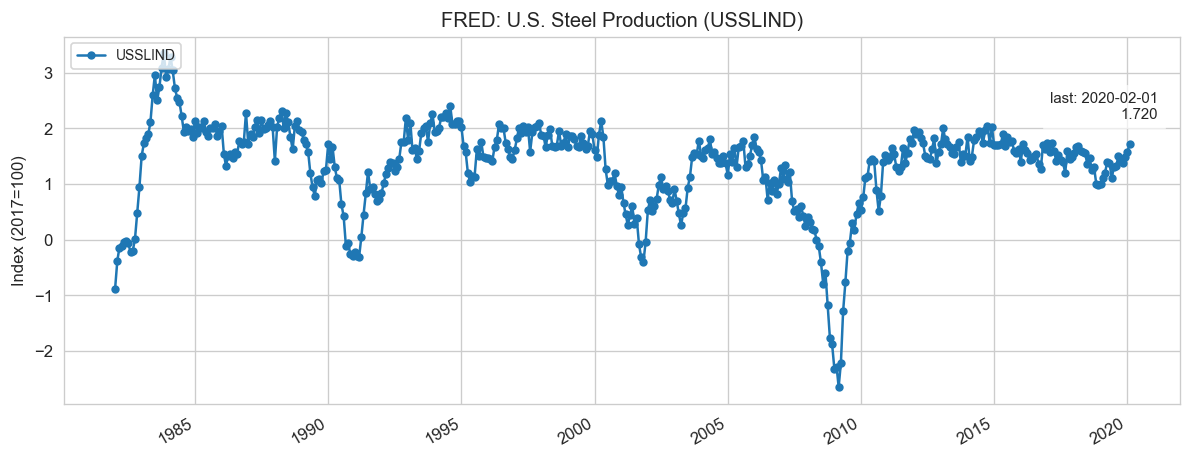

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(USSLIND.index, USSLIND.values, "o-", ms=4, label="USSLIND")
ax.set_title("FRED: U.S. Steel Production (USSLIND)")
ax.set_ylabel("Index (2017=100)")
ax.legend(loc="upper left", fontsize="small")
# annotate last observation
last_dt = USSLIND.index[-1].date()
last_val = USSLIND.iloc[-1]
ax.annotate(f"last: {last_dt}\n{last_val:.3f}", 
            xy=(0.98, 0.85), xycoords="axes fraction",
            ha="right", va="top", fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, linewidth=0.4))
fig.autofmt_xdate(rotation=30)
plt.show()